# Robust Sequence Classification with Adapt𝒪r

This tutorial demonstrates a usage of Adapt𝒪r library for **Sequence Classification** with evaluation of **model robustness** on **adversarial dataset**.

This notebook will show you:

1. How to use a few lines of Adaptor to train a language model for sequence classification
2. How objective-centric approach eases in-training evaluation of the **robustness** of the trained model
3. Whether the longer training helps the accuracy of 

#### Requirements

In [17]:
%%capture

!pip install --upgrade adaptor==0.1.4 datasets==2.1.0

### Dataset resolution

We will use publicly-available CoNLL 2003 dataset for Named Entity Recognition, annotated on the news articles from Reuters Corpus. See e.g. [paperswithcode.com](https://paperswithcode.com/dataset/conll-2003) for more info.

## Datasets resolution

We will fit BERT with sequence classification head on MNLI: Multi-genre Natural Language Inference dataset: you can find more info about this dataset on  [HuggingFace Datasets](https://huggingface.co/datasets/multi_nli) repo.

In [40]:
from datasets import load_dataset

mnli_dataset = load_dataset("multi_nli")
mnli_dataset["train"].column_names

Using custom data configuration default
Reusing dataset multi_nli (/home/xstefan3/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


  0%|          | 0/3 [00:00<?, ?it/s]

['promptID',
 'pairID',
 'premise',
 'premise_binary_parse',
 'premise_parse',
 'hypothesis',
 'hypothesis_binary_parse',
 'hypothesis_parse',
 'genre',
 'label']

By changing the labels for their corresponding value, the objective's model will remember the mapping. You might find that useful, when you'd later need to reload the model only for inference.

In [51]:
label_map = {0: 'entailment', 1: 'non-entailment', 2: 'non-entailment'}

In [127]:
mnli_samples = mnli_dataset["train"].map(lambda sample: {"prem_hyp_pair": "%s\t%s" % (sample["premise"], sample["hypothesis"])})["prem_hyp_pair"]
mnli_labels = [label_map[y] for y in mnli_dataset["train"]["label"]]

Loading cached processed dataset at /home/xstefan3/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-c16e3cc89e4ac246.arrow


In [128]:
len(mnli_samples), len(mnli_labels)

(392702, 392702)

In [53]:
mnli_samples[:5]

['Conceptually cream skimming has two basic dimensions - product and geography.\tProduct and geography are what make cream skimming work. ',
 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him\tYou lose the things to the following level if the people recall.',
 'One of our number will carry out your instructions minutely.\tA member of my team will execute your orders with immense precision.',
 'How do you know? All this is their information again.\tThis information belongs to them.',
 "yeah i tell you what though if you go price some of those tennis shoes i can see why now you know they're getting up in the hundred dollar range\tThe tennis shoes have a range of prices."]

^^ this is a default format of `SequenceClassification` objective: 

* if the task is to classify single texts, each entry in the iterable is a single string
* if the task is to classify a **pair of texts** (NLI case), we **separate the texts with "\t" (tab) symbol**. In the case of NLI, the first text corresponds to a premise and the second to a hypothesis that we are about to decide on.

For all existing Adaptor objectives, the input format consists of a list of texts & labels, or a paths to a `.txt` files with one sample / label per line. See the base `Objective` docs.

In [54]:
mnli_labels[:5]

['non-entailment', 'entailment', 'entailment', 'entailment', 'non-entailment']

ˆ^ each label simply corresponds to a single sample.

Next, we initialise in-domain, validation and test samples:

In [124]:
val_test_mnli_samples = mnli_dataset["validation_matched"].map(lambda sample: {"prem_hyp_pair": "%s\t%s" % (sample["premise"], sample["hypothesis"])})["prem_hyp_pair"]
val_test_mnli_labels = [label_map[y] for y in mnli_dataset["validation_matched"]["label"]]

val_mnli_samples = val_test_mnli_samples[:2000]
val_mnli_labels = val_test_mnli_labels[:2000]

test_mnli_samples = val_test_mnli_samples[2000:]
test_mnli_labels = val_test_mnli_labels[2000:]

Loading cached processed dataset at /home/xstefan3/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-fe275b8de061a139.arrow


### Out-of-domain dataset

During the training, we evaluate our model for the known biases of the NLI models, that were used to compose the **[HANS dataset](https://huggingface.co/datasets/hans)**.

Although that we know that training on this data set will help your model to be more robust, now we use the data only for evaluation.

In [33]:
hans_dataset = load_dataset("hans")

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Dataset hans downloaded and prepared to /home/xstefan3/.cache/huggingface/datasets/hans/plain_text/1.0.0/452e93cf5383f5ae39088254215b517d0da98ccaaf0af8f7ab04d8f23f67dbd9. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
hans_label_map = {0: "entailment", 1: "non-entailment"}

In [70]:
hans_dataset["train"] = hans_dataset["train"].shuffle()
hans_dataset["validation"] = hans_dataset["validation"].shuffle()

hans_samples = hans_dataset["train"].map(lambda sample: {"prem_hyp_pair": "%s\t%s" % (sample["premise"], sample["hypothesis"])})["prem_hyp_pair"]
hans_labels = [hans_label_map[y] for y in hans_dataset["train"]["label"]]

val_hans_samples = hans_dataset["validation"].map(lambda sample: {"prem_hyp_pair": "%s\t%s" % (sample["premise"], sample["hypothesis"])})["prem_hyp_pair"]
val_hans_labels = [hans_label_map[y] for y in hans_dataset["validation"]["label"]]

val_hans_samples = val_hans_samples[:2000]
val_hans_labels = val_hans_labels[:2000]

  0%|          | 0/30000 [00:00<?, ?ex/s]

  0%|          | 0/30000 [00:00<?, ?ex/s]

## Training setup: single-objective NLI

Using Adaptor, we compose our training process from the selected `Objective`s. This is fairly straight with a single fine-tuning Objective.
In addition, we can use an arbirary set of compatible `Evaluator`s. You can also define your own Evaluators (as shown later below).

Adaptor Objectives provide high-level interface, expecting both the input texts and labels in a form of:
* either a `List[str]`, with the texts and labels of the matching length
* or a paths to a `.txt` files with one sample / label per line.

In [131]:
len(mnli_samples), len(mnli_labels)

(392702, 394702)

In [ ]:
from adaptor.objectives.classification import SequenceClassification
from adaptor.evaluators.sequence_classification import SequenceAccuracy
from adaptor.lang_module import LangModule

lang_module = LangModule("bert-base-cased")

evaluators = [SequenceAccuracy()]

mnli_classification = SequenceClassification(lang_module,
                                    batch_size=8,
                                    texts_or_path=mnli_samples,
                                    labels_or_path=mnli_labels,
                                    val_texts_or_path=val_mnli_samples,
                                    val_labels_or_path=val_mnli_labels,
                                    val_evaluators=evaluators,
                                    objective_id="MNLI")

In [135]:
hans_val_classification = SequenceClassification(lang_module,
                                    batch_size=8,
                                    texts_or_path=hans_samples,
                                    labels_or_path=hans_labels,
                                    val_texts_or_path=val_hans_samples,
                                    val_labels_or_path=val_hans_labels,
                                    share_other_objective_head=mnli_classification,
                                    val_evaluators=evaluators,
                                    objective_id="HANS")

Objective HANS-SequenceClassification will use SEQ_CLASSIFICATION head of MNLI-SequenceClassification objective
These layers of the loaded SEQ_CLASSIFICATION were not merged: []


Once we are done with the datasets, objectives and evaluators, we set up the `AdaptationArguments`. These are a small extension of 🤗 's [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.TrainingArguments), the extra parameters are documented with [AdaptationArguments definition](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/utils.py#L77).

In [141]:
from adaptor.utils import StoppingStrategy, AdaptationArguments

training_arguments = AdaptationArguments(output_dir="training_checkpoints",
                                         stopping_strategy=StoppingStrategy.ALL_OBJECTIVES_NUM_EPOCHS,
                                         do_train=True,
                                         do_eval=True,
                                         gradient_accumulation_steps=4,
                                         evaluation_strategy="steps",
                                         # log_level="critical",
                                         logging_steps=100,
                                         eval_steps=100,
                                         num_train_epochs=5,
                                         save_steps=1000)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Then, we define a `Schedule`, defining an order of application of selected `Objective`s. If our training is a single-objective, we can pick any Schedule available - it makes no difference.

In [142]:
from adaptor.schedules import SequentialSchedule

schedule = SequentialSchedule(objectives=[mnli_classification], 
                              extra_eval_objectives=[hans_val_classification],
                              args=training_arguments)

Total number of train samples: 392702
Total number of eval samples: 4000


Finally, we define a main object called `Adapter`: this is again merely a small adjustment of 🤗  [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.Trainer), that takes care of data iteration according to selected `Schedule`, collection of `Objective`s' logs or applying selected multi-objective early-stopping strategy.

In [143]:
from adaptor.adapter import Adapter

adapter = Adapter(lang_module, schedule, training_arguments)

Having the identical iterface, we initialize the training in the same way as with 🤗 Trainer

In [ ]:
adapter.train()

## Training logs analysis

Using the per-objective logs of the training with Adaptor, we aim to answer two questions: **1. does longer fine-tuning helps the robustness of the final model?** and **2. is the early-stopping based on in-domain metrics optimal for choosing the most-robust model?**

<AxesSubplot:>

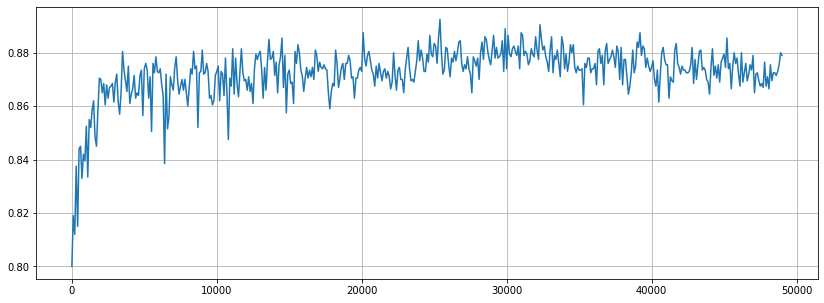

In [160]:
import pandas as pd

mnli_accuracies = pd.Series(mnli_classification.evaluations_history['eval'][evaluators[0]])
hans_accuracies = pd.Series(hans_val_classification.evaluations_history['eval'][evaluators[0]])

index = range(0, len(mnli_accuracies)*training_arguments.eval_steps, training_arguments.eval_steps)
mnli_accuracies.index = index
hans_accuracies.index = index

mnli_accuracies.plot(figsize=(14, 5), grid=True)

<AxesSubplot:>

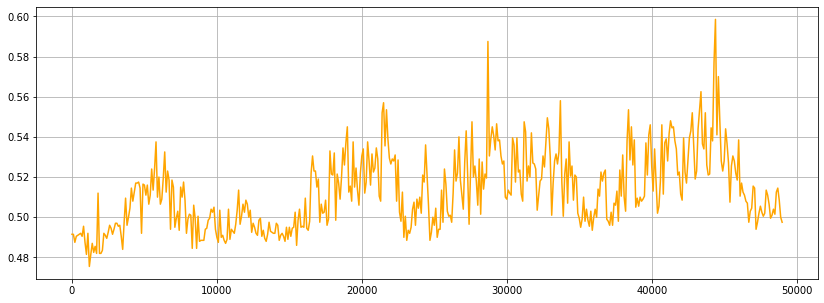

In [161]:
hans_accuracies.plot(figsize=(14, 5), grid=True, color="orange")

<AxesSubplot:>

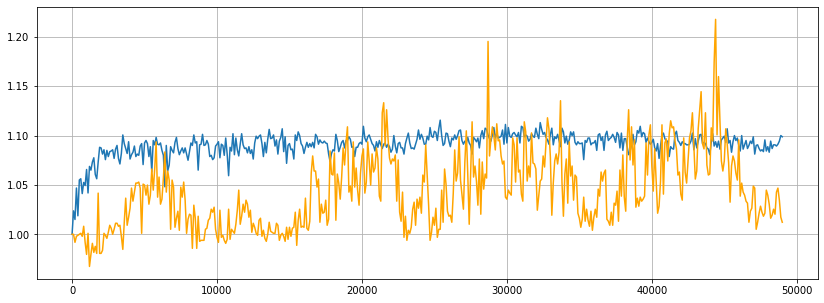

In [162]:
rel_mnli_accuracies = mnli_accuracies / mnli_accuracies[0]
rel_hans_accuracies = hans_accuracies / hans_accuracies[0]

rel_mnli_accuracies.plot(figsize=(14, 5), grid=True)
rel_hans_accuracies.plot(figsize=(14, 5), grid=True, color="orange")

## Training setup: multi-objective NLI (in progress)

Using Adaptor, we compose our training process from the selected `Objective`s. This is fairly straight with a single fine-tuning Objective.
In addition, we can use an arbirary set of compatible `Evaluator`s. You can also define your own Evaluators (as shown later below).

Adaptor Objectives provide high-level interface, expecting both the input texts and labels in a form of:
* either a `List[str]`, with the texts and labels of the matching length
* or a paths to a `.txt` files with one sample / label per line.

In [166]:
from adaptor.objectives.classification import SequenceClassification
from adaptor.evaluators.sequence_classification import SequenceAccuracy
from adaptor.lang_module import LangModule

lang_module = LangModule("bert-base-cased")

evaluators = [SequenceAccuracy()]

mnli_classification_multi = SequenceClassification(lang_module,
                                    batch_size=8,
                                    texts_or_path=mnli_samples,
                                    labels_or_path=mnli_labels,
                                    val_texts_or_path=val_mnli_samples,
                                    val_labels_or_path=val_mnli_labels,
                                    val_evaluators=evaluators,
                                    objective_id="MNLI")

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/xstefan3/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /home/xs

In [167]:
hans_train_classification = SequenceClassification(lang_module,
                                    batch_size=8,
                                    texts_or_path=hans_samples,
                                    labels_or_path=hans_labels,
                                    val_texts_or_path=val_hans_samples,
                                    val_labels_or_path=val_hans_labels,
                                    share_other_objective_head=mnli_classification_multi,
                                    val_evaluators=evaluators,
                                    objective_id="HANS")

Objective HANS-SequenceClassification will use SEQ_CLASSIFICATION head of MNLI-SequenceClassification objective
These layers of the loaded SEQ_CLASSIFICATION were not merged: []


Once we are done with the datasets, objectives and evaluators, we set up the `AdaptationArguments`. These are a small extension of 🤗 's [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.TrainingArguments), the extra parameters are documented with [AdaptationArguments definition](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/utils.py#L77).

In [168]:
from adaptor.utils import StoppingStrategy, AdaptationArguments

training_arguments = AdaptationArguments(output_dir="training_checkpoints",
                                         stopping_strategy=StoppingStrategy.ALL_OBJECTIVES_NUM_EPOCHS,
                                         do_train=True,
                                         do_eval=True,
                                         gradient_accumulation_steps=4,
                                         evaluation_strategy="steps",
                                         # log_level="critical",
                                         logging_steps=100,
                                         eval_steps=100,
                                         num_train_epochs=5,
                                         save_steps=1000)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Then, we define a `Schedule`, defining an order of application of selected `Objective`s. If our training is a single-objective, we can pick any Schedule available - it makes no difference.

In [169]:
from adaptor.schedules import ParallelSchedule

schedule = ParallelSchedule(objectives=[mnli_classification_multi, hans_train_classification], 
                              args=training_arguments)

Total number of train samples: 422702
Total number of eval samples: 4000


Finally, we define a main object called `Adapter`: this is again merely a small adjustment of 🤗  [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.Trainer), that takes care of data iteration according to selected `Schedule`, collection of `Objective`s' logs or applying selected multi-objective early-stopping strategy.

In [170]:
from adaptor.adapter import Adapter

adapter = Adapter(lang_module, schedule, training_arguments)

Having the identical iterface, we initialize the training in the same way as with 🤗 Trainer

In [ ]:
adapter.train()